In [1]:
from utils.tf import *
from utils.db import *
from utils.gd import * 
from utils.clt_repetidos import *
from datetime import datetime
import cx_Oracle
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from utils.clt_repetidos import * 
from ydata_profiling import ProfileReport
import dask.dataframe as dd
import gc
import matplotlib.pyplot as plt


In [2]:
path = "/home/ale1726/proyects/datalake/clientes/data/productos/FFON"

# Obtención de data

In [10]:
query_sistemas_ffon = """
WITH MOVI_X_SISTEMA AS (
	SELECT 
	CFE_C_SISTEMA,
	COUNT(*) AS NUM_TRANSACCIONES
	FROM FLUFON.CFE_M_OPERACION
	GROUP BY CFE_C_SISTEMA
), MOVI_X_SISTEMA_CAT AS (
	SELECT CFE_C_SISTEMA, DESCRIPCION_DCAT_S NOMBRE_SISTEMA, CORTO_DCAT_S SISTEMA, NUM_TRANSACCIONES
	FROM MOVI_X_SISTEMA MOV
	LEFT JOIN FLUFON.ASI_D_CATALOGO ADC ON MOV.CFE_C_SISTEMA  = ADC.ASI_D_CATALOGO 
) SELECT * FROM MOVI_X_SISTEMA_CAT
"""

In [11]:
get_table(path, db_ffon, "agrupado_sistemas_presentes", query=query_sistemas_ffon)

'/home/ale1726/proyects/datalake/clientes/data/productos/FFON/agrupado_sistemas_presentes.dat'

In [7]:
def bloque_datos(sistema):
    return f"""
    WITH CLIENTES AS (
			SELECT *
				FROM FLUFON.CFE_M_OPERACION 
			WHERE CFE_C_SISTEMA IN ({sistema})
		), CLIE_CONCEPTO AS (
			SELECT CT.*, ADC1.DESCRIPCION_DCAT_S CONCEPTO, ADC1.CORTO_DCAT_S CODIGO_CONCEPTO
			FROM CLIENTES CT
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC1 ON ADC1.ASI_D_CATALOGO = CT.CFE_C_SUBCONCEPTO
		), CLIE_DEPARTAMENTO AS (
			SELECT CP.*, ADC2.DESCRIPCION_DCAT_S DEPARTAMENTO, ADC2.CORTO_DCAT_S CODIGO_DEPARTAMENTO
			FROM CLIE_CONCEPTO CP
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC2 ON ADC2.ASI_D_CATALOGO = CP.CFE_C_DEPARTAMENTO
		), CLIE_BENEFICIERO AS (
			SELECT CD.*, ADC2.DESCRIPCION_DCAT_S BENEFICIARIO, ADC2.CORTO_DCAT_S ID_ORIGEN
			FROM CLIE_DEPARTAMENTO CD
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC2 ON ADC2.ASI_D_CATALOGO = CD.CFE_C_BENEFICIARIO	
		), CLI_CTA_INTERNA AS(
			SELECT CB.*, ADC2.DESCRIPCION_DCAT_S CTA_INTERNA, ADC2.CORTO_DCAT_S CODIGO_CTA_INTERNA
			FROM CLIE_BENEFICIERO CB
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC2 ON ADC2.ASI_D_CATALOGO = CB.CFE_C_CTA_INTERNA	
		), CLI_VIA AS (
			SELECT CI.*, ADC2.DESCRIPCION_DCAT_S VIA, ADC2.CORTO_DCAT_S CODIGO_VIA
			FROM CLI_CTA_INTERNA CI
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC2 ON ADC2.ASI_D_CATALOGO = CI.CFE_C_VIA
		), CLIENTES_DATOS AS (
			SELECT CV.*, CUENTA_BEN_S, CALLE_BEN_S, NUM_BEN_S, COLONIA_BEN_S, 
			MUNICIPIO_BEN_S,TEL_BEN_S,CP_BEN_S,CONTACTO_BEN_S, NOMBRE_BEN_S,
			AP_BEN_S,AM_BEN_S,RFC_BEN_S,PAIS_BEN_I,ENTIDAD_BEN_I,TIPO_BEN_I,
			RAZONSOC_BEN_S, CE_BEN_S, STATUS_CE_BEN_N
			FROM CLI_VIA CV
			LEFT JOIN FLUFON.CFE_C_BENEFICIARIO CFBE ON CV.CFE_C_BENEFICIARIO = CFBE.CFE_C_BENEFICIARIO
		), CLIENTE_PAIS AS (
			SELECT CD.*,  ADC3.CORTO_DCAT_S CODIGO_PAIS, ADC3.DESCRIPCION_DCAT_S PAIS
			FROM CLIENTES_DATOS CD 
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC3 ON CD.PAIS_BEN_I = ADC3.ASI_D_CATALOGO
		), CLIENTE_ENT AS (
			SELECT CD.*,  ADC3.CORTO_DCAT_S CODIGO_ENTIDAD, ADC3.DESCRIPCION_DCAT_S ENTIDAD
			FROM CLIENTE_PAIS CD 
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC3 ON CD.ENTIDAD_BEN_I = ADC3.ASI_D_CATALOGO
		), CFE_D_CTA_BEN_BANCO AS (
			SELECT  CFE_C_BENEFICIARIO, 
			CUENTA_BEN_S, CFE_C_BANCO,
			CFE_C_PLAZA, CFE_C_SUCURSAL,
			CFE_C_DIVISA,CFE_C_TIPO_CTA, IDENT_CTA_BEN_N, STATUS_CTA_BEN_N,
			ADC3.CORTO_DCAT_S CODIGO_BANCO, ADC3.DESCRIPCION_DCAT_S BANCO
			FROM FLUFON.CFE_D_CTABEN CDC
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC3 ON CDC.CFE_C_BANCO = ADC3.ASI_D_CATALOGO
		), CFE_D_CTA_BEN_DIVISA AS (
			SELECT  CFE_C_BENEFICIARIO, CUENTA_BEN_S, CFE_C_BANCO, CFE_C_PLAZA, CFE_C_SUCURSAL, 
			CFE_C_DIVISA, CFE_C_TIPO_CTA, IDENT_CTA_BEN_N, STATUS_CTA_BEN_N, CODIGO_BANCO, BANCO, 
			ADC3.CORTO_DCAT_S CODIGO_DIVISA, ADC3.DESCRIPCION_DCAT_S DIVISA
			FROM CFE_D_CTA_BEN_BANCO CDC
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC3 ON CDC.CFE_C_DIVISA = ADC3.ASI_D_CATALOGO
		), CFE_D_CTA_BEN_PLAZA AS (
			SELECT  CFE_C_BENEFICIARIO CFE_C_BENEFICIARIO_2, CUENTA_BEN_S, CFE_C_BANCO, CFE_C_PLAZA, CFE_C_SUCURSAL, 
			CFE_C_DIVISA, CFE_C_TIPO_CTA, IDENT_CTA_BEN_N, STATUS_CTA_BEN_N, CODIGO_BANCO, BANCO, CODIGO_DIVISA, DIVISA,
			ADC3.CORTO_DCAT_S CODIGO_PLAZA, ADC3.DESCRIPCION_DCAT_S PLAZA
			FROM CFE_D_CTA_BEN_DIVISA CDC
			LEFT JOIN FLUFON.ASI_D_CATALOGO ADC3 ON CDC.CFE_C_PLAZA = ADC3.ASI_D_CATALOGO
		), TAB_FINAL AS (
			SELECT CFE_M_OPERACION, CFE_C_BENEFICIARIO, FVALOR_OPE_DT, FVENC_OPE_DT, MONTOENT_OPE_N, MONTOSAL_OPE_N, 
			DESCRIPCION_OPE_S, CONCEPTO, DEPARTAMENTO, ID_ORIGEN, BENEFICIARIO, CTA_INTERNA, VIA, CALLE_BEN_S, 
			NUM_BEN_S, COLONIA_BEN_S, MUNICIPIO_BEN_S, TEL_BEN_S, CP_BEN_S, CONTACTO_BEN_S, NOMBRE_BEN_S, AP_BEN_S, AM_BEN_S,
			RFC_BEN_S, PAIS_BEN_I, ENTIDAD_BEN_I, TIPO_BEN_I, RAZONSOC_BEN_S, CE_BEN_S, STATUS_CE_BEN_N, 
			PAIS, ENTIDAD, CE.CUENTA_BEN_S CUENTA_BENS_2, CDBP.CUENTA_BEN_S, BANCO, PLAZA, DIVISA
			FROM CLIENTE_ENT CE
			LEFT JOIN CFE_D_CTA_BEN_PLAZA CDBP ON CDBP.CFE_C_BENEFICIARIO_2 = CE.CFE_C_BENEFICIARIO
		) SELECT * FROM TAB_FINAL
    """

In [8]:
sistemas_transaccionales = {
    "TAS":  2052,
    "MECA": 109691,
    "SOME": 423603,
    "SIRAC":2050,
    "SIMS": 238761,
    "SOI":  228370,
    "SIPE": 174039
}

In [ ]:
for sistema, id in sistemas_transaccionales.items():
    get_table(path, db_ffon, f"movimientos_ffon_{sistema}", query=bloque_datos(id))

In [4]:
query_agrupado_1 = """
WITH AGRUPADO_SUBCONCEPTOS AS (
	SELECT
    CFE_C_SUBCONCEPTO AS NUM_CONCEPTO,
    COUNT(CFE_M_OPERACION) AS NUM_OPERACIONES,
    AVG(MONTOENT_OPE_N) AS MEDIA_MONTO,
    SUM(MONTOENT_OPE_N) AS SUMA_MONTO,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY MONTOENT_OPE_N) AS MEDIANA_MONTO
	FROM FLUFON.CFE_M_OPERACION
	GROUP BY CFE_C_SUBCONCEPTO
), TAB_FINAL AS ( 
	SELECT NUM_CONCEPTO, DESCRIPCION_DCAT_S CONCEPTO, NUM_OPERACIONES, MEDIA_MONTO, SUMA_MONTO, MEDIANA_MONTO
	FROM AGRUPADO_SUBCONCEPTOS AGS
	LEFT JOIN FLUFON.ASI_D_CATALOGO ADC ON AGS.NUM_CONCEPTO  = ADC.ASI_D_CATALOGO 
) SELECT * FROM TAB_FINAL
"""

In [5]:
get_table(path, db_ffon, f"agrupado_ffon_subconceptos", query=query_agrupado_1)

'/home/ale1726/proyects/datalake/clientes/data/productos/FFON/agrupado_ffon_subconceptos.dat'

# Exploracion sistema FFON

In [23]:
agrupado_sistemas_presentes  = pd.read_csv(f"{path}/agrupado_sistemas_presentes.dat")

In [24]:
agrupado_sistemas_presentes["NUM_TRANSACCIONES"].sum()

62310739

In [88]:
agrupado_sistemas_presentes

,CFE_C_SISTEMA,NOMBRE_SISTEMA,SISTEMA,NUM_TRANSACCIONES
0,2052,SISTEMA TAS,TAS,1533975
1,2055,SISTEMA IKOS CASH WEB,WEB FFON,111479
2,2053,SISTEMA CUSTODIA DE VALORES,CUSTODIA,1086272
3,109691,SISTEMA DE MERCADO DE CAPITALES,MECA,13949
4,128716,SISTEMA DE VENTAS EN DIRECTO,SVD,54780080
5,187951,SISTEMA DE DERIVADOS Y CAMBIOS,SIDECA,275229
6,423603,SISTEMA DE OPERACIONES MONEDA EXTRANJERA,SOME,10418
7,2054,SISTEMA IKOS CASH,FFON,4114656
8,2050,SISTEMA SIRAC,SIRAC,164043
9,238761,SISTEMA DE MERCADO SECUNDARIO,SIMS,339


In [ ]:
agrupado_sistemas_presentes.SISTEMA,  agrupado_sistemas_presentes.NUM_TRANSACCIONES

,CFE_C_SISTEMA,NOMBRE_SISTEMA,SISTEMA,NUM_TRANSACCIONES
0,2052,SISTEMA TAS,TAS,1533975
1,2055,SISTEMA IKOS CASH WEB,WEB FFON,111479
2,2053,SISTEMA CUSTODIA DE VALORES,CUSTODIA,1086272
3,109691,SISTEMA DE MERCADO DE CAPITALES,MECA,13949
4,128716,SISTEMA DE VENTAS EN DIRECTO,SVD,54780080
5,187951,SISTEMA DE DERIVADOS Y CAMBIOS,SIDECA,275229
6,423603,SISTEMA DE OPERACIONES MONEDA EXTRANJERA,SOME,10418
7,2054,SISTEMA IKOS CASH,FFON,4114656
8,2050,SISTEMA SIRAC,SIRAC,164043
9,238761,SISTEMA DE MERCADO SECUNDARIO,SIMS,339


In [94]:
[[sistema, numtransacciones] for sistema, numtransacciones in zip(agrupado_sistemas_presentes["SISTEMA"], agrupado_sistemas_presentes["NUM_TRANSACCIONES"]) if sistema != 'CARGA MASIVA']

[['TAS', 1533975],
 ['WEB FFON', 111479],
 ['CUSTODIA', 1086272],
 ['MECA', 13949],
 ['SVD', 54780080],
 ['SIDECA', 275229],
 ['SOME', 10418],
 ['FFON', 4114656],
 ['SIRAC', 164043],
 ['SIMS', 339],
 ['SOI', 186],
 ['SIPE', 31401],
 ['NAFIN', 188706]]

In [95]:
fig = px.bar(agrupado_sistemas_presentes, 
             x="SISTEMA", 
             y="NUM_TRANSACCIONES", 
             title="Número de Transacciones por Sistema",
             log_y=True)
fig.show()

In [18]:
agrupado_sistemas_presentes

,CFE_C_SISTEMA,NOMBRE_SISTEMA,SISTEMA,NUM_TRANSACCIONES
0,2052,SISTEMA TAS,TAS,1533975
1,2055,SISTEMA IKOS CASH WEB,WEB FFON,111479
2,2053,SISTEMA CUSTODIA DE VALORES,CUSTODIA,1086272
3,109691,SISTEMA DE MERCADO DE CAPITALES,MECA,13949
4,128716,SISTEMA DE VENTAS EN DIRECTO,SVD,54780080
5,187951,SISTEMA DE DERIVADOS Y CAMBIOS,SIDECA,275229
6,423603,SISTEMA DE OPERACIONES MONEDA EXTRANJERA,SOME,10418
7,2054,SISTEMA IKOS CASH,FFON,4114656
8,2050,SISTEMA SIRAC,SIRAC,164043
9,238761,SISTEMA DE MERCADO SECUNDARIO,SIMS,339


In [96]:
def analizar_columnas_problematicas(df, umbral_cardinalidad=0.9):
    """
    Analiza columnas problemáticas en un DataFrame.

    Parámetros:
        df: pd.DataFrame
        umbral_cardinalidad: float (entre 0 y 1). 
            Define cuántos valores únicos se permiten antes de considerar una columna como de alta cardinalidad.
    
    Devuelve:
        Dict con sugerencias por tipo de problema.
    """
    total_filas = len(df)
    resultado = {
        "todas_nulas": [],
        "alta_cardinalidad": [],
        "tipo_id_grande": [],
        "tipos_malos": [],
    }

    for col in df.columns:
        serie = df[col]
        nunicos = serie.nunique(dropna=True)

        # Todas nulas
        if serie.isnull().sum() == total_filas:
            resultado["todas_nulas"].append(col)

        # Alta cardinalidad
        elif nunicos / total_filas > umbral_cardinalidad and serie.dtype == "object":
            resultado["alta_cardinalidad"].append(col)

        # IDs mal tipificados (ej: números muy grandes en float/int)
        elif pd.api.types.is_numeric_dtype(serie) and serie.max() > 1e12:
            resultado["tipo_id_grande"].append(col)

        # Columnas float que parecen texto (por tener todos NaN o pocos valores)
        elif pd.api.types.is_float_dtype(serie) and nunicos < 5:
            resultado["tipos_malos"].append(col)

    return resultado


In [97]:
def preparar_para_profiling(df, eliminar_nulas=True, convertir_objetos=True, convertir_ids=True):
    """
    Devuelve una copia del DataFrame listo para `ydata_profiling`.

    Parámetros:
        eliminar_nulas: elimina columnas completamente nulas.
        convertir_objetos: convierte objetos de baja cardinalidad a 'category'.
        convertir_ids: convierte columnas numéricas muy grandes a string.
    """
    df = df.copy()

    if eliminar_nulas:
        df = df.loc[:, df.notnull().any()]

    if convertir_ids:
        for col in df.select_dtypes(include=['int64', 'float64']).columns:
            if df[col].max() > 1e12:
                df[col] = df[col].astype(str)

    if convertir_objetos:
        for col in df.select_dtypes(include='object').columns:
            if df[col].nunique() / len(df) < 0.5:
                df[col] = df[col].astype('category')

    # Reducir tamaño de floats e ints
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')

    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = df[col].astype('int32')

    return df


In [103]:
archivos = [archivo for archivo in os.listdir(path) if "movimiento" in archivo]

### ejemplo

In [ ]:
df = pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/productos/FFON/movimientos_ffon_MECA.dat", low_memory=False)
# Ver columnas problemáticas
problemas = analizar_columnas_problematicas(df)
for tipo, columnas in problemas.items():
    print(f"\n{tipo.upper()}:\n{columnas}")


df_limpio = preparar_para_profiling(df)
from ydata_profiling import ProfileReport
report = ProfileReport(df_limpio, title="Informe EDA limpio")
report.to_file("informe_limpio.html")



TODAS_NULAS:
['DESCRIPCION_OPE_S', 'NUM_BEN_S', 'COLONIA_BEN_S', 'MUNICIPIO_BEN_S', 'TEL_BEN_S', 'CP_BEN_S', 'CONTACTO_BEN_S', 'AP_BEN_S', 'AM_BEN_S', 'CE_BEN_S', 'CUENTA_BENS_2']

ALTA_CARDINALIDAD:
[]

TIPO_ID_GRANDE:
['CUENTA_BEN_S']

TIPOS_MALOS:
['PAIS_BEN_I', 'ENTIDAD_BEN_I']


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9 9 8 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecate

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Generar reporte

In [102]:
for archivo in archivos:
    try:
        df = pd.read_csv(os.path.join(path, archivo), low_memory=False)
        sistema = archivo.split('_')[2].split('.')[0]
        print(f'Procesando Informe EDA ffon {sistema}')
        print(f"Registros: {df.shape[0]:,d}")
        print(f"Memoria: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

        df_limpio = preparar_para_profiling(df)
        
        nombre_reporte = f"my_report_ffon_{sistema}.html"
        ruta_reporte = os.path.join('/home/ale1726/proyects/datalake/clientes/data/productos/FFON/reportes', nombre_reporte)

        report = ProfileReport(df_limpio, title=f'Informe EDA ffon {sistema}', progress_bar=True)
        report.to_file(ruta_reporte)

        print(f"Reporte generado: {ruta_reporte}\n")

    except Exception as e:
        print(f"Error procesando {archivo}: {e}\n")

    finally:
        del df
        gc.collect()


Procesando Informe EDA ffon MECA
Registros: 27,143
Memoria: 36.74 MB


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9 9 8 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte generado: /home/ale1726/proyects/datalake/clientes/data/productos/FFON/reportes/my_report_ffon_MECA.html

Procesando Informe EDA ffon SIMS
Registros: 1,017
Memoria: 1.37 MB


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4 4 4 ... 4 4 4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4 4 4 ... 4 4 4]' has dtype incompatible with int32, please

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte generado: /home/ale1726/proyects/datalake/clientes/data/productos/FFON/reportes/my_report_ffon_SIMS.html

Procesando Informe EDA ffon SIPE
Registros: 82,292
Memoria: 122.29 MB


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9 9 9 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte generado: /home/ale1726/proyects/datalake/clientes/data/productos/FFON/reportes/my_report_ffon_SIPE.html

Procesando Informe EDA ffon SIRAC
Registros: 581,476
Memoria: 937.31 MB


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/pandas/core/nanops.py:1348: RuntimeWarning:

overflow encountered in square

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/pandas/core/nanops.py:1348: RuntimeWarning:

overflow encountered in square

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte generado: /home/ale1726/proyects/datalake/clientes/data/productos/FFON/reportes/my_report_ffon_SIRAC.html

Procesando Informe EDA ffon SOI
Registros: 400
Memoria: 0.57 MB


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/pandas/core/nanops.py:1348: RuntimeWarning:

overflow encountered in square

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte generado: /home/ale1726/proyects/datalake/clientes/data/productos/FFON/reportes/my_report_ffon_SOI.html

Procesando Informe EDA ffon SOME
Registros: 10,476
Memoria: 13.16 MB


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4 4 4 ... 4 4 4]' has dtype incompatible with int32, please

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte generado: /home/ale1726/proyects/datalake/clientes/data/productos/FFON/reportes/my_report_ffon_SOME.html

Procesando Informe EDA ffon TAS
Registros: 2,064,841
Memoria: 2965.45 MB


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/pandas/core/nanops.py:1348: RuntimeWarning:

overflow encountered in square

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9 9 9 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 2 2 2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

/home/ale1726/proyects/datalake/myenv_1/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

Setting an item o

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte generado: /home/ale1726/proyects/datalake/clientes/data/productos/FFON/reportes/my_report_ffon_TAS.html



### Generar reporte valores nulos 

Procesando gráfico de nulos ffon MECA
Registros: 27,143
Memoria: 36.74 MB


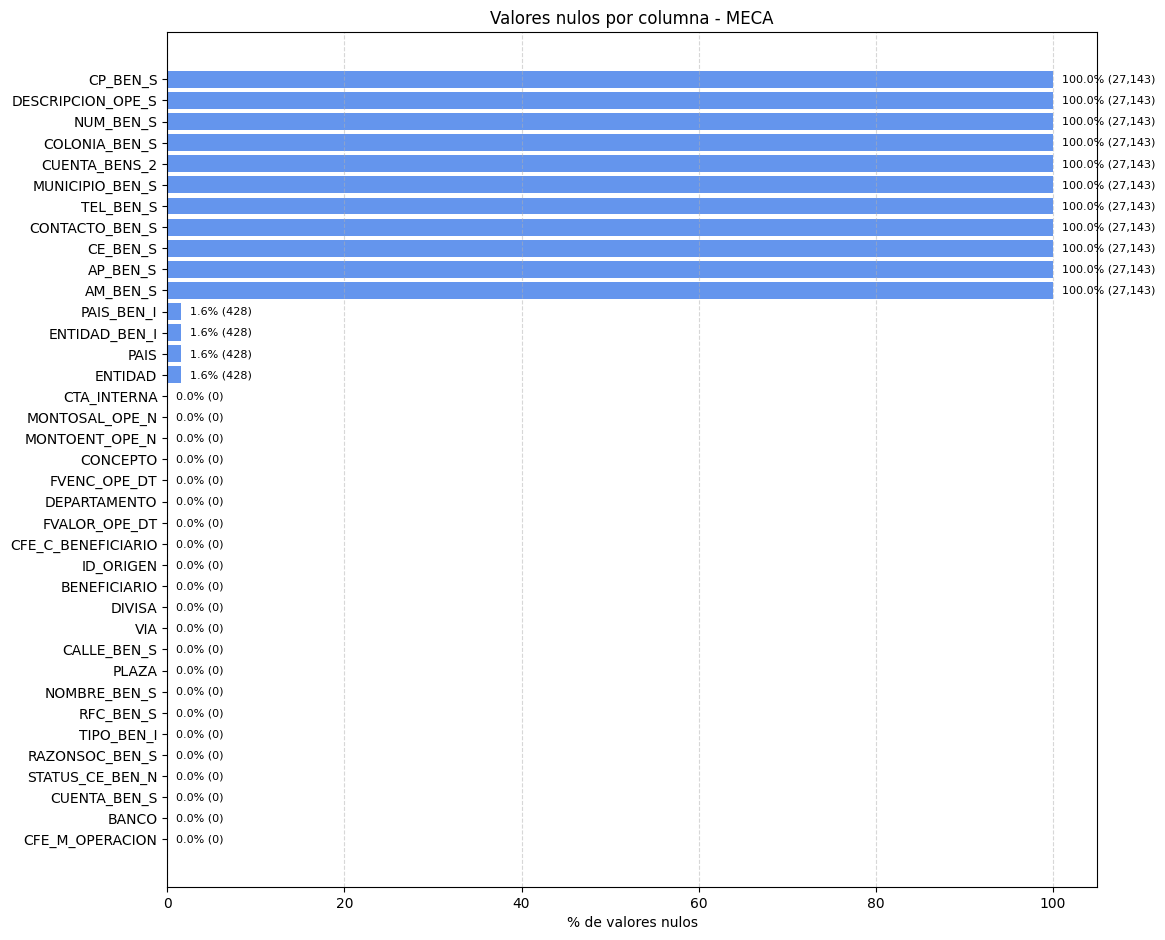


Procesando gráfico de nulos ffon SIMS
Registros: 1,017
Memoria: 1.37 MB


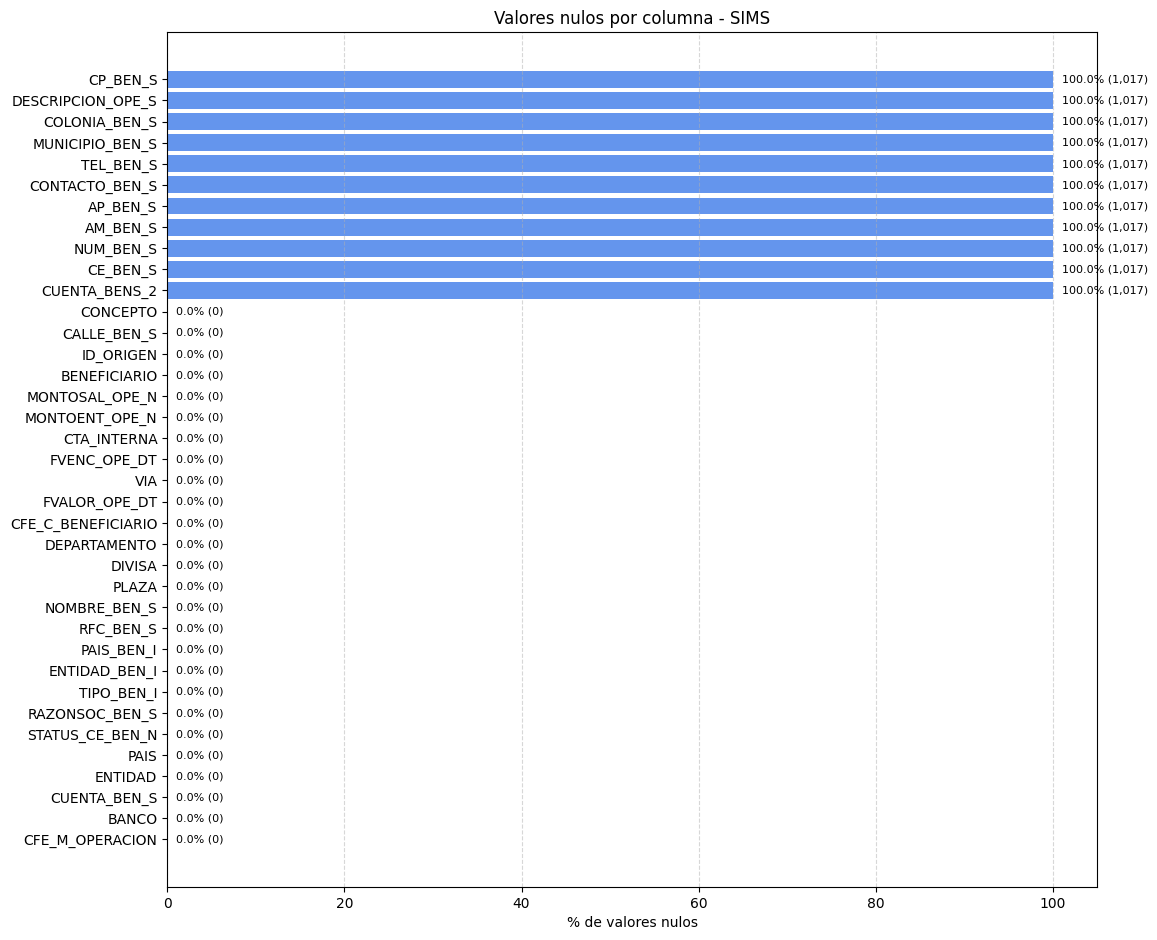


Procesando gráfico de nulos ffon SIPE
Registros: 82,292
Memoria: 122.29 MB


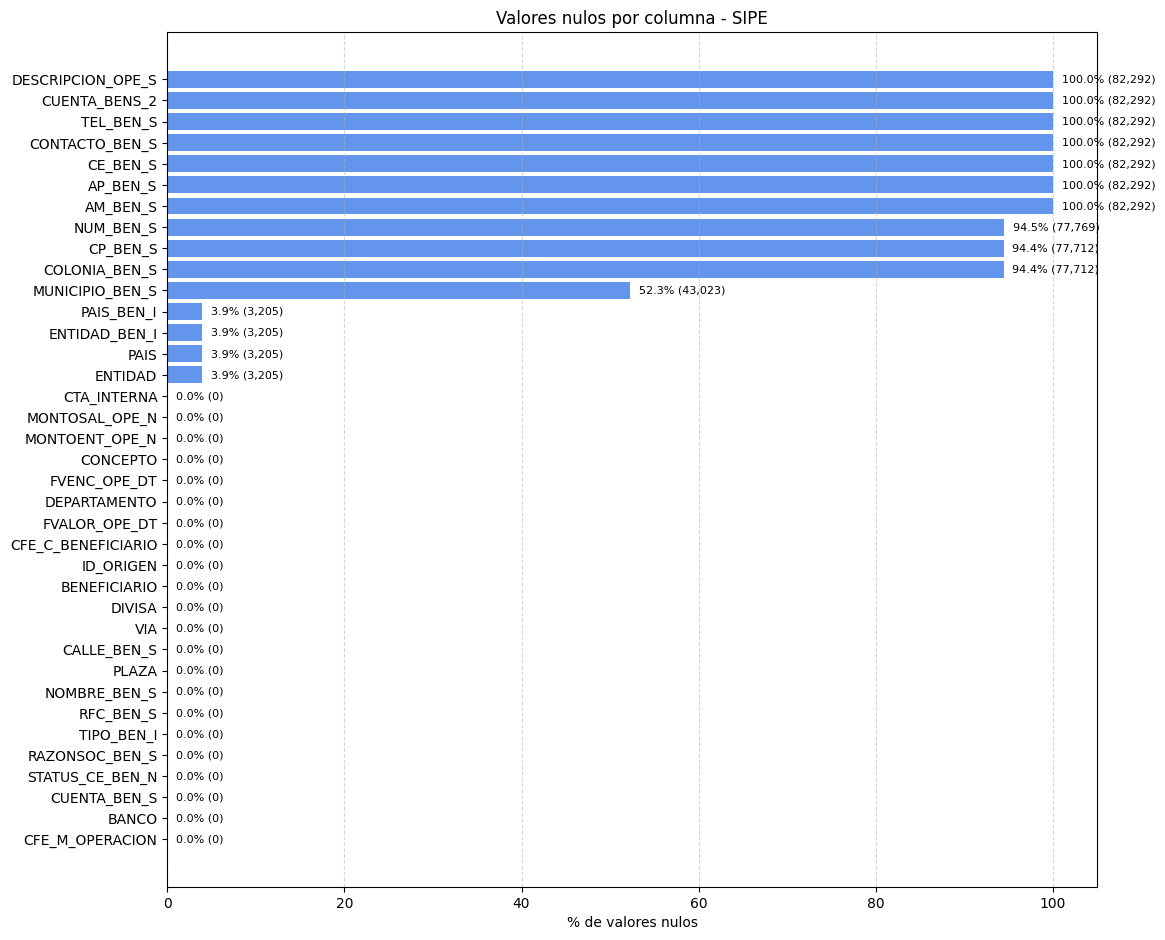


Procesando gráfico de nulos ffon SIRAC
Registros: 581,476
Memoria: 937.31 MB


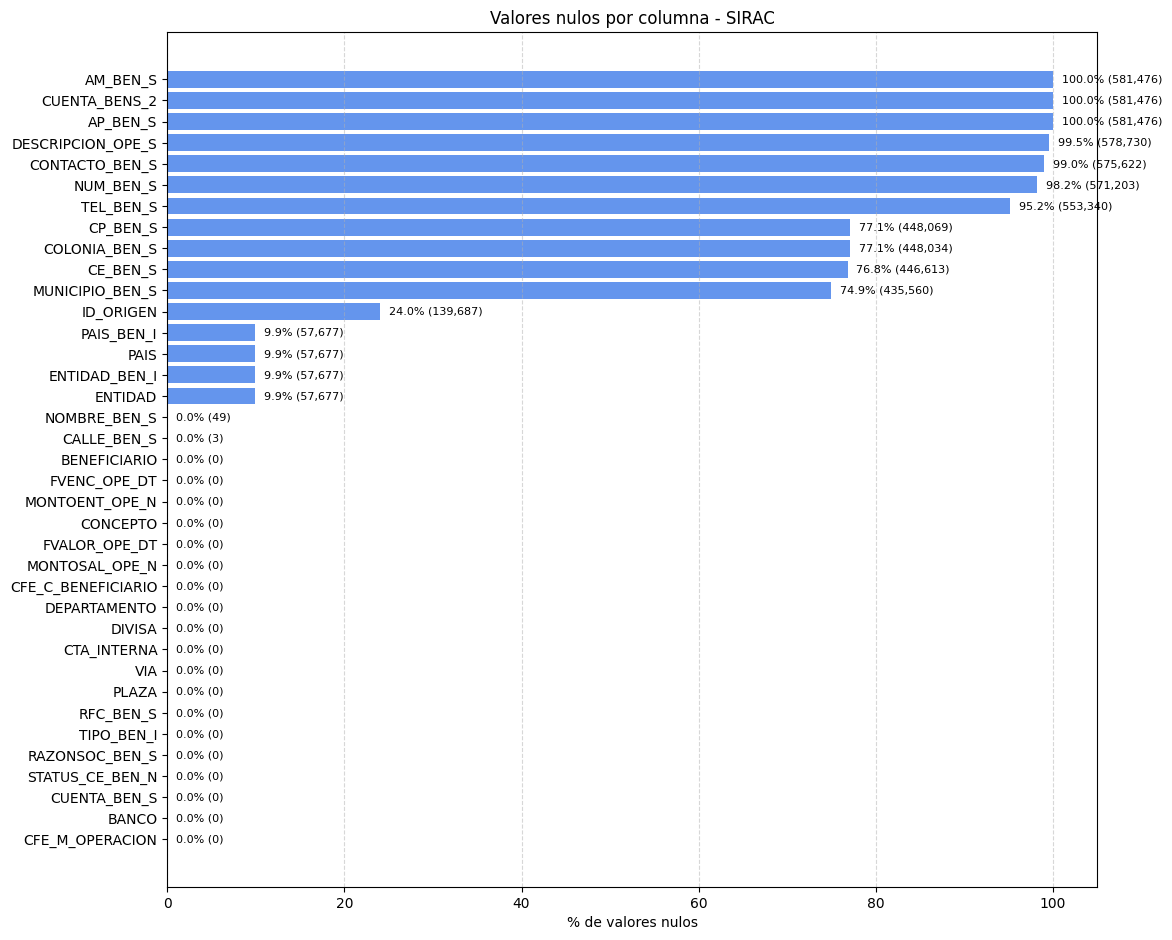


Procesando gráfico de nulos ffon SOI
Registros: 400
Memoria: 0.57 MB


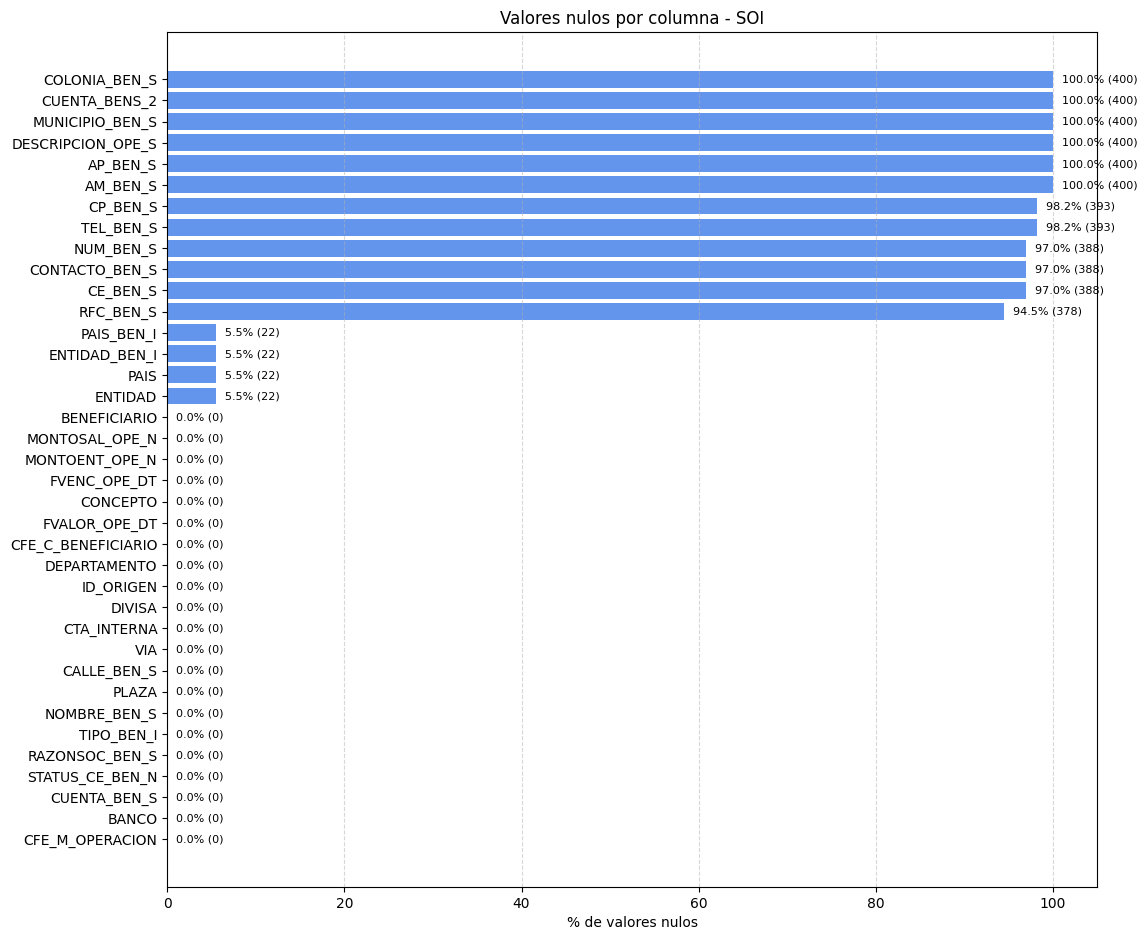


Procesando gráfico de nulos ffon SOME
Registros: 10,476
Memoria: 13.16 MB


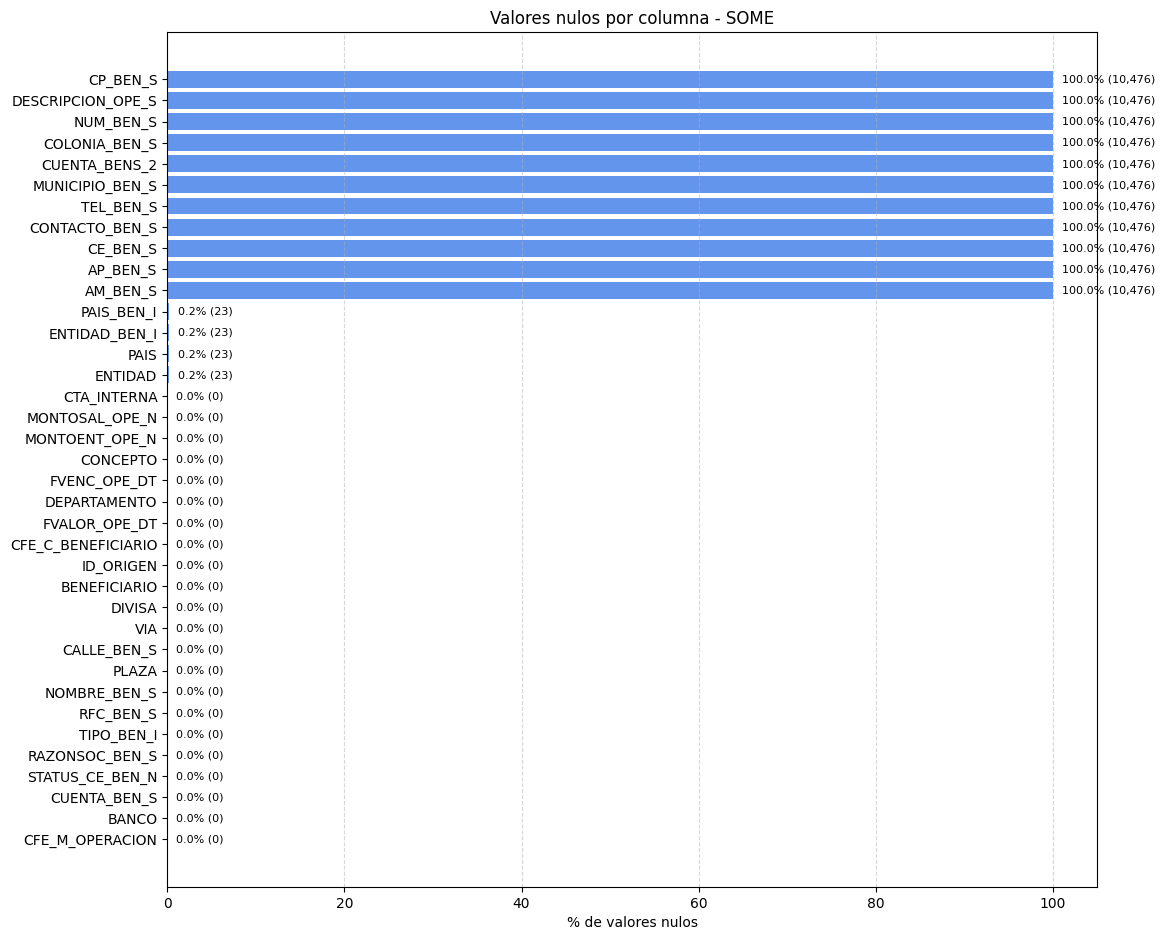


Procesando gráfico de nulos ffon TAS
Registros: 2,064,841
Memoria: 2965.45 MB


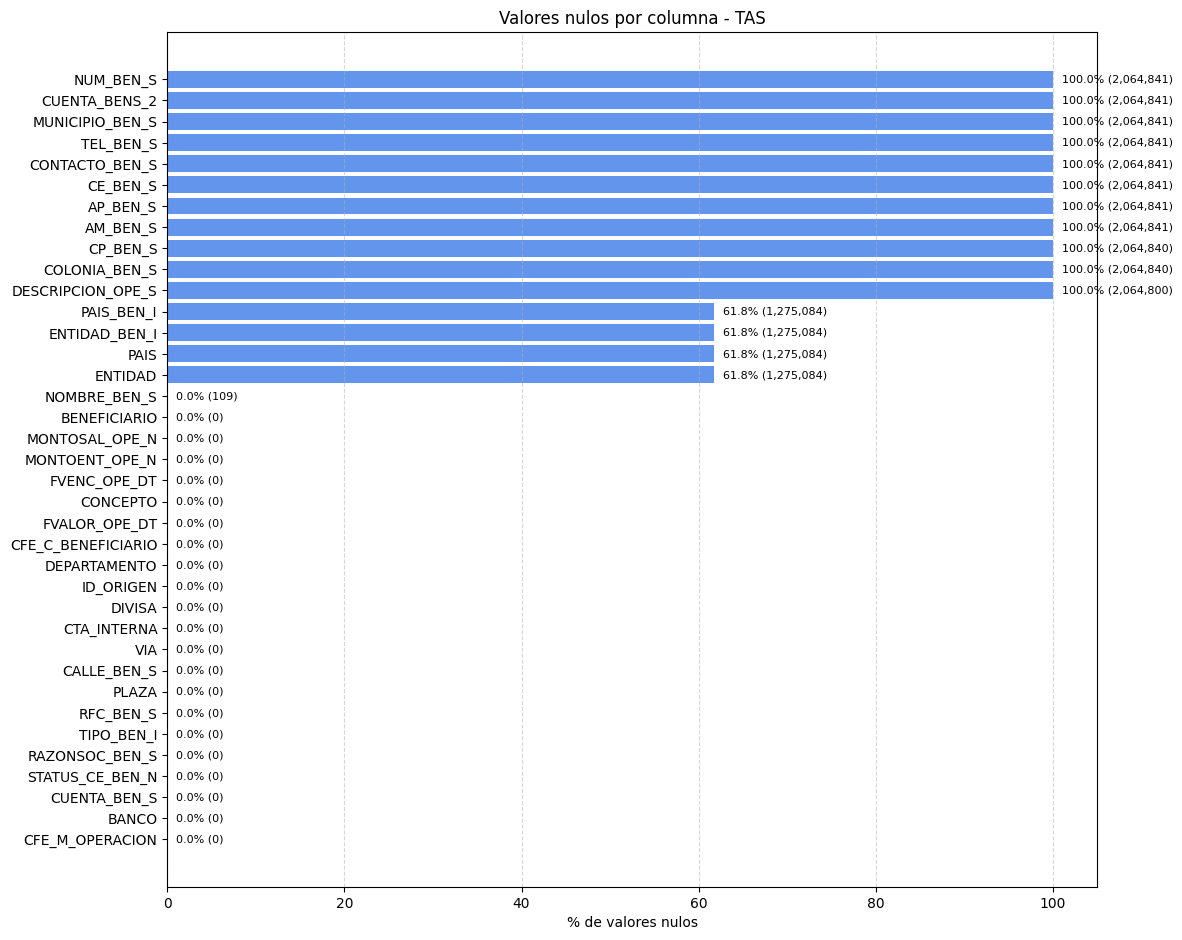

In [112]:
%matplotlib inline

for archivo in archivos:
    try:
        df = pd.read_csv(os.path.join(path, archivo), low_memory=False)
        sistema = archivo.split('_')[2].split('.')[0]

        print(f'Procesando gráfico de nulos ffon {sistema}')
        print(f"Registros: {df.shape[0]:,d}")
        print(f"Memoria: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

        # ==== Gráfico directamente en el ciclo ====
        total = len(df)
        nulos_abs = df.isnull().sum()
        nulos_pct = (nulos_abs / total * 100).sort_values(ascending=True)

        plt.figure(figsize=(12, max(6, len(df.columns) * 0.3)))
        bars = plt.barh(nulos_pct.index, nulos_pct.values, color='cornflowerblue')

        for i, bar in enumerate(bars):
            valor = nulos_abs[nulos_pct.index[i]]
            plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                     f'{nulos_pct.iloc[i]:.1f}% ({valor:,d})', va='center', fontsize=8)

        plt.xlabel('% de valores nulos')
        plt.title(f'Valores nulos por columna - {sistema}')
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.show()
        # ==========================================

        print()

    except Exception as e:
        print(f"Error procesando {archivo}: {e}\n")

    finally:
        del df
        gc.collect()


# Comparación de clientes en meca en ffon

In [9]:
df_meca = pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/clientes_activos/24_02_2025/Clientes_activos_MECA.dat", low_memory=False)

In [ ]:
df_meca = pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/clientes_activos/24_02_2025/Clientes_activos_MECA.dat", low_memory=False)


In [4]:
df_meca_ffon = pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/productos/FFON/movimientos_ffon_MECA.dat", low_memory=False)  

In [14]:
df_meca_ffon["BENEFICIARIO"].nunique()

22

In [16]:
df_meca_ffon_filtred = df_meca_ffon.drop_duplicates(subset='RAZONSOC_BEN_S')


In [17]:
clt_repetidos = compara_nombres(df_meca, df_meca_ffon_filtred, 'NOMBRE_O_RAZON_SOCIAL', 'RAZONSOC_BEN_S', 'NUMERO_CLIENTE', 'ID_ORIGEN', 95)

In [18]:
clt_repetidos

,ID1,NUM_CLIENTE_1,CLIENTE_1,ID2,NUM_CLIENTE_2,CLIENTE_2
0,3,ACTINV,ACTINVER CASA DE BOLSA,17369,CB ACTINVER,ACTINVER CASA DE BOLSA
1,80,BARCAP,"BARCLAYS CAPITAL CASA DE BOLSA, S.A. DE C.V.",4064,/,"BARCLAYS CAPITAL CASA DE BOLSA, S.A. DE C.V."
2,97,BNORT,"CASA DE BOLSA BANORTE, S.A. DE C.V",17367,CB BANORTE,"CASA DE BOLSA BANORTE, S.A. DE C.V"
3,98,BBVA,"CASA DE BOLSA BBVA BANCOMER, S.A. DE C.V.",280,CB BBVA,"CASA DE BOLSA BBVA BANCOMER, S.A. DE C.V."
4,99,CREDIS,"CASA DE BOLSA CREDIT SUISSE (MÉXICO), S.A. DE ...",4692,CB CREDIS,"CASA DE BOLSA CREDIT SUISSE (MÉXICO), S.A. DE ..."
5,100,MULTIV,"CASA DE BOLSA MULTIVA, S.A. DE C.V. GRUPO FINA...",12600,CB MULTIVA,"CASA DE BOLSA MULTIVA, S.A. DE C.V. GRUPO FINA..."
6,101,SANTA,"CASA DE BOLSA SANTANDER MEXICO, S.A. DE C.V.",270,CB SANTANDER,"CASA DE BOLSA SANTANDER MEXICO, S.A. DE C.V."
7,102,BXMAS,"CASA DE BOLSA VE POR MAS, S.A. DE C. V.",17297,CB ARKA,"CASA DE BOLSA VE POR MAS, S.A. DE C. V."
8,115,CICB,"CI, CASA DE BOLSA",480,CB CI,"CI, CASA DE BOLSA"
9,157,HSBC,"HSBC CASA DE BOLSA, S.A. DE .C.V. GRUPO FINANC...",14945,CB HSBC,"HSBC CASA DE BOLSA, S.A. DE .C.V. GRUPO FINANC..."


In [147]:
for cliente in df_meca_ffon_filtred["ID_ORIGEN"].unique():
    if cliente not in clt_repetidos["NUM_CLIENTE_2"].unique():
        razon_social = df_meca_ffon_filtred.loc[df_meca_ffon_filtred["ID_ORIGEN"] == cliente, "RAZONSOC_BEN_S"].iloc[0]
        print(f"{razon_social} no está en df_meca")


S.D. INDEVAL, S.A. DE C.V. no está en df_meca
UBS CASA DE BOLSA, S.A. DE C.V. no está en df_meca


# Comparación de clientes en tas en ffon

In [35]:
df_ffon_tas = pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/productos/FFON/movimientos_ffon_TAS.dat", low_memory=False)

In [70]:
df_ffon_tas.value_counts("CONCEPTO")

CONCEPTO
INICIO DE VENTA REPORTO          638331
VENCIMIENTO VENTA EN REPORTO     409226
INICIO DE VENTA DIRECTO          221432
INICIO DE COMPRA REPORTO         176619
INICIO DE COMPRA EN DIRECTO      131508
PAGO DE CAPITAL                  128285
VENCIMIENTO DE COMPRA REPORTO    108457
COBRO DE CUPON                    74123
INICIO DE INVERSION               44767
VENCIMIENTO DE INVERSION          21965
INGRESO BXICOFTAS                 19177
EGRESOS BXICO FTAS                19155
RETIRO DE EFECTIVO                16470
DEPOSITO                          14122
VENCIMIENTO DE DEPOSITO           11825
INICIO DE DEPOSITO RECIBIDO       11807
PAGO DE CUPON                     11510
VENCIMIENTO DE PRESTAMO            3032
INICIO DE PRESTAMO                 3030
Name: count, dtype: int64

In [27]:
df_tas = pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/ETL/27_01_2025/CLientesT_TAS.csv", low_memory=False)

In [44]:
df_productos = pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/productos/TAS/data/26_02_2025/productos_clientes_TAS.dat", low_memory=False)

In [52]:
df_productos.head()

,NUMERO_CLIENTE,ESPROVEED,TIPO_PERSONA,NOMBRE,NOMLARGO,RFC,NLINEA,ICONTRATO,IORDEN,FOPER,...,DIA_FVENCE,IINSTR,ITINSTR,NTINSTR,TASA,MONEDA,MONTO,MONTO_ASIGNADO,MONTO_REAL,FECHA_REGISTRO
0,1040153,1,Moral Nacional no Gravable,BANXICO,BANCO DE MEXICO,BNM840515VB2,01040153,1040153,430215,2020-11-12 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,4.25,MXP,3.302570e+09,3.302570e+09,3.302570e+09,2020-11-12 00:00:00
1,51000,0,Cuentas Propias,GARANTIAS CREDITO,GARANTIAS CREDITO,NFI3406305T0,00051000,51000,430214,2020-11-12 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,4.25,MXP,3.297121e+09,3.297121e+09,3.297121e+09,2020-11-12 00:00:00
2,1040153,1,Moral Nacional no Gravable,BANXICO,BANCO DE MEXICO,BNM840515VB2,01040153,1040153,430100,2020-11-12 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,4.25,MXP,3.302570e+09,0.000000e+00,3.308033e+09,2020-11-12 00:00:00
3,51000,0,Cuentas Propias,GARANTIAS CREDITO,GARANTIAS CREDITO,NFI3406305T0,00051000,51000,430063,2020-11-12 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,4.25,MXP,3.302570e+09,0.000000e+00,3.308033e+09,2020-11-12 00:00:00
4,1040153,1,Moral Nacional no Gravable,BANXICO,BANCO DE MEXICO,BNM840515VB2,01040153,1040153,329069,2020-04-01 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,6.50,MXP,5.217593e+09,5.217593e+09,5.217593e+09,2020-04-01 00:00:00


In [ ]:
1059992, 1063322

In [86]:
df_productos[df_productos["NUMERO_CLIENTE"] == 1063322]

,NUMERO_CLIENTE,ESPROVEED,TIPO_PERSONA,NOMBRE,NOMLARGO,RFC,NLINEA,ICONTRATO,IORDEN,FOPER,...,DIA_FVENCE,IINSTR,ITINSTR,NTINSTR,TASA,MONEDA,MONTO,MONTO_ASIGNADO,MONTO_REAL,FECHA_REGISTRO
145148,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,885713,2009-05-15 00:00:00,...,18,PAGARE,BANCAR,PAPELES BANCARIOS EN GRAL,5.24,MXP,2.500000e+08,2.500000e+08,2.500000e+08,2009-05-15 00:00:00
145227,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,884926,2009-05-14 00:00:00,...,15,PAGARE,BANCAR,PAPELES BANCARIOS EN GRAL,5.99,MXP,2.500000e+08,2.500000e+08,2.500000e+08,2009-05-14 00:00:00
145265,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,884007,2009-05-13 00:00:00,...,14,PAGARE,BANCAR,PAPELES BANCARIOS EN GRAL,5.99,MXP,3.000000e+08,3.000000e+08,3.000000e+08,2009-05-13 00:00:00
145362,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,883055,2009-05-12 00:00:00,...,13,PAGARE,BANCAR,PAPELES BANCARIOS EN GRAL,6.00,MXP,2.000000e+08,2.000000e+08,2.000000e+08,2009-05-12 00:00:00
146387,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,874001,2009-04-24 00:00:00,...,27,PAGARE,BANCAR,PAPELES BANCARIOS EN GRAL,5.94,MXP,1.000000e+08,1.000000e+08,1.000000e+08,2009-04-24 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362576,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,936252,2018-09-14 00:00:00,...,17,,GUBERR,PAPEL GUBERNAMENTAL,7.75,MXP,3.000000e+08,3.000000e+08,3.000000e+08,2018-09-14 00:00:00
1386470,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,116159,2019-02-01 00:00:00,...,5,,GUBERR,PAPEL GUBERNAMENTAL,8.22,MXP,1.999999e+08,1.999999e+08,1.999999e+08,2019-02-01 00:00:00
1387502,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,117409,2019-02-06 00:00:00,...,7,,GUBERR,PAPEL GUBERNAMENTAL,8.15,MXP,3.000000e+08,3.000000e+08,3.000000e+08,2019-02-06 00:00:00
1388514,1063322,1,Moral Nacional no Gravable,BANCO AHORRO FAMSA,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ...",BAF060524FV6,1063322,1063322,116385,2019-02-05 00:00:00,...,6,,GUBERR,PAPEL GUBERNAMENTAL,8.35,MXP,9.999990e+07,9.999990e+07,9.999990e+07,2019-02-05 00:00:00


In [75]:
df_productos.columns

Index(['NUMERO_CLIENTE', 'ESPROVEED', 'TIPO_PERSONA', 'NOMBRE', 'NOMLARGO',
       'RFC', 'NLINEA', 'ICONTRATO', 'IORDEN', 'FOPER', 'A?O_OPE', 'MES_OPE',
       'DIA_OPE', 'FLIQ', 'A?O_FLIQ', 'MES_FLIQ', 'DIA_FLIQ', 'CPZO_DE',
       'CPZO_A', 'PLAZOREF', 'FVENCE', 'A?O_FVENCE', 'MES_FVENCE',
       'DIA_FVENCE', 'IINSTR', 'ITINSTR', 'NTINSTR', 'TASA', 'MONEDA', 'MONTO',
       'MONTO_ASIGNADO', 'MONTO_REAL', 'FECHA_REGISTRO'],
      dtype='object')

In [81]:
df_productos[df_productos["NUMERO_CLIENTE"].astype(str).str.contains('1065733', na=False)]

,NUMERO_CLIENTE,ESPROVEED,TIPO_PERSONA,NOMBRE,NOMLARGO,RFC,NLINEA,ICONTRATO,IORDEN,FOPER,...,DIA_FVENCE,IINSTR,ITINSTR,NTINSTR,TASA,MONEDA,MONTO,MONTO_ASIGNADO,MONTO_REAL,FECHA_REGISTRO
1663972,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,726674,2022-10-14 00:00:00,...,17,,GUBERR,PAPEL GUBERNAMENTAL,9.20,MXP,8840000.0,8.839980e+06,8840000.0,2022-10-14 00:00:00
1664884,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,724371,2022-10-10 00:00:00,...,11,,GUBERR,PAPEL GUBERNAMENTAL,9.16,MXP,8380000.0,8.379915e+06,8380000.0,2022-10-10 00:00:00
1665344,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,723852,2022-10-07 00:00:00,...,10,,GUBERR,PAPEL GUBERNAMENTAL,9.13,MXP,8370000.0,8.369901e+06,8370000.0,2022-10-07 00:00:00
1666110,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,723214,2022-10-06 00:00:00,...,7,,GUBERR,PAPEL GUBERNAMENTAL,9.20,MXP,8370000.0,8.369964e+06,8370000.0,2022-10-06 00:00:00
1666197,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,722648,2022-10-05 00:00:00,...,6,,GUBERR,PAPEL GUBERNAMENTAL,9.20,MXP,8370000.0,8.369925e+06,8370000.0,2022-10-05 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902047,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,110346,2024-08-21 00:00:00,...,22,,GUBERR,PAPEL GUBERNAMENTAL,10.71,MXP,193000000.0,1.930000e+08,193000000.0,2024-08-21 00:00:00
1902490,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,113519,2024-08-28 00:00:00,...,29,,GUBERR,PAPEL GUBERNAMENTAL,10.73,MXP,210200000.0,2.102000e+08,210200000.0,2024-08-28 00:00:00
1902686,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,109002,2024-08-19 00:00:00,...,20,,GUBERR,PAPEL GUBERNAMENTAL,10.70,MXP,193900000.0,1.939000e+08,193900000.0,2024-08-19 00:00:00
1902947,1065733,0,Moral Nacional no Gravable,CRECE 2 (XIGNUX),"CRECE SISTEMA PATRIMONIAL, A.C.",CSP010426480,1065733,1065733,109742,2024-08-20 00:00:00,...,21,,GUBERR,PAPEL GUBERNAMENTAL,10.71,MXP,193800000.0,1.938000e+08,193800000.0,2024-08-20 00:00:00


In [ ]:
101950000.0

In [84]:
87677341.93 *4 > 101950000.0

True

In [82]:
df_ffon_tas[df_ffon_tas["ID_ORIGEN"] == '1062763']


,CFE_M_OPERACION,CFE_C_BENEFICIARIO,FVALOR_OPE_DT,FVENC_OPE_DT,MONTOENT_OPE_N,MONTOSAL_OPE_N,DESCRIPCION_OPE_S,CONCEPTO,DEPARTAMENTO,ID_ORIGEN,...,RAZONSOC_BEN_S,CE_BEN_S,STATUS_CE_BEN_N,PAIS,ENTIDAD,CUENTA_BENS_2,CUENTA_BEN_S,BANCO,PLAZA,DIVISA
213388,19315939,32976,2019-01-02 00:00:00,2019-01-02 00:00:00,162300000.0,0.000000e+00,NaN,INICIO DE INVERSION,DINERO,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,021580040210880757,HSBC MEXICO SA INSTITUCION DE BANCA MULTIPLE G...,"MEXICO, DF",PESO MEXICANO
213389,19315939,32976,2019-01-02 00:00:00,2019-01-02 00:00:00,162300000.0,0.000000e+00,NaN,INICIO DE INVERSION,DINERO,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,021180040570479538,HSBC MEXICO SA INSTITUCION DE BANCA MULTIPLE G...,"MEXICO, DF",PESO MEXICANO
213390,19315939,32976,2019-01-02 00:00:00,2019-01-02 00:00:00,162300000.0,0.000000e+00,NaN,INICIO DE INVERSION,DINERO,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,021580040210882991,HSBC MEXICO SA INSTITUCION DE BANCA MULTIPLE G...,"MEXICO, DF",PESO MEXICANO
213391,19315939,32976,2019-01-02 00:00:00,2019-01-02 00:00:00,162300000.0,0.000000e+00,NaN,INICIO DE INVERSION,DINERO,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,072580001611661974,"BANCO MERCANTIL DEL NORTE, S.A. , INSTITUCION ...","GARZA GARCIA, NL",PESO MEXICANO
213392,19311188,32976,2019-01-02 00:00:00,2019-01-02 00:00:00,162300000.0,0.000000e+00,NaN,INICIO DE INVERSION,DINERO,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,021580040210880757,HSBC MEXICO SA INSTITUCION DE BANCA MULTIPLE G...,"MEXICO, DF",PESO MEXICANO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758660,48802359,33155,2022-05-04 00:00:00,2022-05-04 00:00:00,0.0,2.724493e+08,NaN,RETIRO DE EFECTIVO,CAJA TAS,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,072580001611661974,"BANCO MERCANTIL DEL NORTE, S.A. , INSTITUCION ...","GARZA GARCIA, NL",PESO MEXICANO
1758661,48802240,33155,2022-05-04 00:00:00,2022-05-04 00:00:00,0.0,2.724493e+08,NaN,RETIRO DE EFECTIVO,CAJA TAS,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,021580040210880757,HSBC MEXICO SA INSTITUCION DE BANCA MULTIPLE G...,"MEXICO, DF",PESO MEXICANO
1758662,48802240,33155,2022-05-04 00:00:00,2022-05-04 00:00:00,0.0,2.724493e+08,NaN,RETIRO DE EFECTIVO,CAJA TAS,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,021180040570479538,HSBC MEXICO SA INSTITUCION DE BANCA MULTIPLE G...,"MEXICO, DF",PESO MEXICANO
1758663,48802240,33155,2022-05-04 00:00:00,2022-05-04 00:00:00,0.0,2.724493e+08,NaN,RETIRO DE EFECTIVO,CAJA TAS,1062763,...,"CRECE SISTEMA PATRIMONIAL, A.C.",NaN,1,NaN,NaN,NaN,021580040210882991,HSBC MEXICO SA INSTITUCION DE BANCA MULTIPLE G...,"MEXICO, DF",PESO MEXICANO


In [77]:
df_productos["MONTO"][df_productos["NUMERO_CLIENTE"].astype(str).str.contains('1065733', na=False)].sum()

88098707457.31454

In [78]:
df_ffon_tas["MONTOENT_OPE_N"][df_ffon_tas["ID_ORIGEN"] == '1062763'].sum()


3056055523772.76

In [68]:
df_filtred.describe()

,CFE_M_OPERACION,CFE_C_BENEFICIARIO,MONTOENT_OPE_N,MONTOSAL_OPE_N,DESCRIPCION_OPE_S,NUM_BEN_S,MUNICIPIO_BEN_S,TEL_BEN_S,CP_BEN_S,CONTACTO_BEN_S,AP_BEN_S,AM_BEN_S,PAIS_BEN_I,ENTIDAD_BEN_I,TIPO_BEN_I,CE_BEN_S,STATUS_CE_BEN_N,CUENTA_BENS_2
count,1.491200e+04,14912.000000,1.491200e+04,1.491200e+04,16.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14912.0,0.0,14912.0,0.0
mean,4.252380e+07,32976.288090,2.049393e+08,1.010972e+08,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
std,1.796176e+07,7.175555,1.736858e+08,1.590058e+08,6.196773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
min,1.931119e+07,32976.000000,0.000000e+00,0.000000e+00,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
25%,2.725076e+07,32976.000000,0.000000e+00,0.000000e+00,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
50%,3.870713e+07,32976.000000,2.119750e+08,0.000000e+00,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
75%,5.505105e+07,32976.000000,3.367100e+08,2.099722e+08,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
max,8.519994e+07,33155.000000,5.629700e+08,5.634954e+08,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN


In [65]:
df_filtred.columns

Index(['CFE_M_OPERACION', 'CFE_C_BENEFICIARIO', 'FVALOR_OPE_DT',
       'FVENC_OPE_DT', 'MONTOENT_OPE_N', 'MONTOSAL_OPE_N', 'DESCRIPCION_OPE_S',
       'CONCEPTO', 'DEPARTAMENTO', 'ID_ORIGEN', 'BENEFICIARIO', 'CTA_INTERNA',
       'VIA', 'CALLE_BEN_S', 'NUM_BEN_S', 'COLONIA_BEN_S', 'MUNICIPIO_BEN_S',
       'TEL_BEN_S', 'CP_BEN_S', 'CONTACTO_BEN_S', 'NOMBRE_BEN_S', 'AP_BEN_S',
       'AM_BEN_S', 'RFC_BEN_S', 'PAIS_BEN_I', 'ENTIDAD_BEN_I', 'TIPO_BEN_I',
       'RAZONSOC_BEN_S', 'CE_BEN_S', 'STATUS_CE_BEN_N', 'PAIS', 'ENTIDAD',
       'CUENTA_BENS_2', 'CUENTA_BEN_S', 'BANCO', 'PLAZA', 'DIVISA'],
      dtype='object')

In [67]:
df_filtred.value_counts("DEPARTAMENTO")

DEPARTAMENTO
DINERO      14888
CAJA TAS       24
Name: count, dtype: int64

In [ ]:
df_filtred[df_filtred["MONTOENT_OPE_N"]  == 0]

In [ ]:
df_filtred = df_ffon_tas[df_ffon_tas["ID_ORIGEN"] == '1062763']

In [36]:
df_ffon_tas_filtred = df_ffon_tas.drop_duplicates(subset='RAZONSOC_BEN_S')

In [31]:
df_ffon_tas_filtred = df_ffon_tas_filtred.drop_duplicates(subset='RAZONSOC_BEN_S')

In [40]:
clt_repetidos_tas = compara_nombres(df_tas, df_ffon_tas_filtred, 'NOMBRE_O_RAZON_SOCIAL', 'RAZONSOC_BEN_S', 'NUMERO_CLIENTE', 'ID_ORIGEN', 99)

In [41]:
clt_repetidos_tas

,ID1,NUM_CLIENTE_1,CLIENTE_1,ID2,NUM_CLIENTE_2,CLIENTE_2
0,55,"1065418, 1065564","ALSOL CONTIGO S.A. DE C.V. SOFOM, E.N.R.",1593797,1065418,"ALSOL CONTIGO S.A. DE C.V. SOFOM, E.N.R."
1,55,"1065418, 1065564","ALSOL CONTIGO S.A. DE C.V. SOFOM, E.N.R.",1876853,1065564,"ALSOL CONTIGO, S.A. DE C.V., SOFOM, E.N.R."
2,82,"6009444, 6009445, 1065793","ASEGURADORA ASERTA, S.A. DE C.V.",1460568,1065793,"ASEGURADORA ASERTA, S.A. DE C.V."
3,83,"1065794, 6009447, 6009448",ASEGURADORA INSURGENTES S.A. DE C.V.,1971862,1065794,ASEGURADORA INSURGENTES S.A. DE C.V.
4,114,"1059992, 1063322",BANCO AHORRO FAMSA S.A. INSTITUCION DE BANCA M...,317482,1063322,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ..."
...,...,...,...,...,...,...
487,1969,1055053,"Z REFEX 1 S.A. DE C.V., F.I.I.D.",1508197,1055053,"Z REFEX 1 S.A. DE C.V., F.I.I.D."
488,1970,1055045,"Z REFMO 1 S.A. DE C.V., F.I.I.D.",1247450,1055045,"Z REFMO 1 S.A. DE C.V., F.I.I.D."
489,1971,1055002,"ZCAP 3 S.A. DE C.V., F.I.R.V.",807038,1055002,"ZCAP 3 S.A. DE C.V., F.I.R.V."
490,1974,6009454,"ZURICH CAPABILITY CENTER MEXICO, S.A. DE C.V.",987685,6009454,"ZURICH CAPABILITY CENTER MEXICO, S.A. DE C.V."


In [26]:
clt_repetidos_tas

,ID1,NUM_CLIENTE_1,CLIENTE_1,ID2,NUM_CLIENTE_2,CLIENTE_2
1,55,"1065418, 1065564","ALSOL CONTIGO S.A. DE C.V. SOFOM, E.N.R.",1593797,1065418,"ALSOL CONTIGO S.A. DE C.V. SOFOM, E.N.R."
2,55,"1065418, 1065564","ALSOL CONTIGO S.A. DE C.V. SOFOM, E.N.R.",1876853,1065564,"ALSOL CONTIGO, S.A. DE C.V., SOFOM, E.N.R."
3,82,"6009444, 6009445, 1065793","ASEGURADORA ASERTA, S.A. DE C.V.",1460568,1065793,"ASEGURADORA ASERTA, S.A. DE C.V."
4,83,"1065794, 6009447, 6009448",ASEGURADORA INSURGENTES S.A. DE C.V.,1971862,1065794,ASEGURADORA INSURGENTES S.A. DE C.V.
5,114,"1059992, 1063322",BANCO AHORRO FAMSA S.A. INSTITUCION DE BANCA M...,317482,1063322,"BANCO AHORRO FAMSA, S.A. INSTITUCION DE BANCA ..."
...,...,...,...,...,...,...
1105,1969,1055053,"Z REFEX 1 S.A. DE C.V., F.I.I.D.",1508197,1055053,"Z REFEX 1 S.A. DE C.V., F.I.I.D."
1106,1970,1055045,"Z REFMO 1 S.A. DE C.V., F.I.I.D.",1247450,1055045,"Z REFMO 1 S.A. DE C.V., F.I.I.D."
1107,1971,1055002,"ZCAP 3 S.A. DE C.V., F.I.R.V.",807038,1055002,"ZCAP 3 S.A. DE C.V., F.I.R.V."
1108,1974,6009454,"ZURICH CAPABILITY CENTER MEXICO, S.A. DE C.V.",987685,6009454,"ZURICH CAPABILITY CENTER MEXICO, S.A. DE C.V."


# Analisis exploratorio FFON - MECA

In [4]:
df_meca_ffon = pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/productos/FFON/movimientos_ffon_MECA.dat", low_memory=False) 

In [12]:
df_meca_ffon.columns

Index(['CFE_M_OPERACION', 'CFE_C_BENEFICIARIO', 'FVALOR_OPE_DT',
       'FVENC_OPE_DT', 'MONTOENT_OPE_N', 'MONTOSAL_OPE_N', 'DESCRIPCION_OPE_S',
       'CONCEPTO', 'DEPARTAMENTO', 'ID_ORIGEN', 'BENEFICIARIO', 'CTA_INTERNA',
       'VIA', 'CALLE_BEN_S', 'NUM_BEN_S', 'COLONIA_BEN_S', 'MUNICIPIO_BEN_S',
       'TEL_BEN_S', 'CP_BEN_S', 'CONTACTO_BEN_S', 'NOMBRE_BEN_S', 'AP_BEN_S',
       'AM_BEN_S', 'RFC_BEN_S', 'PAIS_BEN_I', 'ENTIDAD_BEN_I', 'TIPO_BEN_I',
       'RAZONSOC_BEN_S', 'CE_BEN_S', 'STATUS_CE_BEN_N', 'PAIS', 'ENTIDAD',
       'CUENTA_BENS_2', 'CUENTA_BEN_S', 'BANCO', 'PLAZA', 'DIVISA'],
      dtype='object')

In [ ]:
columnas = ['CONCEPTO','DEPARTAMENTO','CTA_INTERNA','VIA','PAIS','BANCO','PLAZA', 'DIVISA']

In [22]:
df_meca_ffon.value_counts("DESCRIPCION_OPE_S")

Series([], Name: count, dtype: int64)

In [16]:
df_meca_ffon.value_counts("CONCEPTO")

CONCEPTO
COMPRA DE ACCIONES                 13480
VENTA DE ACCIONES                  12711
DIVIDENDOS EN EFECTIVO               542
PREMIOS POR PRESTAMO DE VALORES      410
Name: count, dtype: int64

In [17]:
df_meca_ffon.value_counts("DEPARTAMENTO")

DEPARTAMENTO
CAPITALES    27143
Name: count, dtype: int64

In [18]:
df_meca_ffon.value_counts("DIVISA")

DIVISA
PESO MEXICANO      26873
DOLAR AMERICANO      270
Name: count, dtype: int64

In [19]:
df_meca_ffon.value_counts("VIA")

VIA
Salida Indeval     13890
Entrada Indeval    12711
DEPOSITO             542
Name: count, dtype: int64

In [20]:
df_meca_ffon.value_counts("BANCO")

BANCO
Banco de Mexico                                                        17654
CI CASA DE BOLSA                                                        3584
INTERCAM CASA DE BOLSA SA DE CV                                         3157
IXE Casa de Bolsa, S.A. de C.V.                                         1193
ACTINVER CASA DE BOLSA S.A. DE C.V.                                      765
BBVA BANCOMER, S.A. INSTITUCION DE BANCA MULTIPLE, GPO FINANCIERO B      270
Deutsche Bank Americas, New York                                         270
Casa de Bolsa BBVA BANCOMER, S.A. de C.V.                                200
CASA DE BOLSA MULTIVA S.A. DE C.V.  GPO. FIN. MULTIVA                     36
CASA DE BOLSA SANTANDER, S.A. DE C.V. GPO FINANCIERO SANTANDER            10
Casa de Bolsa Banorte, S.A. de C.V.                                        2
INTERACCIONES CASA DE BOLSA, S.A. DE C.V. GPO FIN INTERACCION              2
Name: count, dtype: int64

In [21]:
df_meca_ffon.value_counts("PLAZA")

PLAZA
MEXICO, DF       26873
NEW YORK, NY.      270
Name: count, dtype: int64

In [11]:
df_meca_ffon[df_meca_ffon["PAIS"] == "IRLANDA"]

,CFE_M_OPERACION,CFE_C_BENEFICIARIO,FVALOR_OPE_DT,FVENC_OPE_DT,MONTOENT_OPE_N,MONTOSAL_OPE_N,DESCRIPCION_OPE_S,CONCEPTO,DEPARTAMENTO,ID_ORIGEN,...,RAZONSOC_BEN_S,CE_BEN_S,STATUS_CE_BEN_N,PAIS,ENTIDAD,CUENTA_BENS_2,CUENTA_BEN_S,BANCO,PLAZA,DIVISA
480,78487574,195091,2023-08-30 00:00:00,2023-08-30 00:00:00,353380.60,0.00,NaN,VENTA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,1,Banco de Mexico,"MEXICO, DF",PESO MEXICANO
481,78437929,195091,2023-08-29 00:00:00,2023-08-29 00:00:00,424711.85,0.00,NaN,VENTA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,1,Banco de Mexico,"MEXICO, DF",PESO MEXICANO
482,78345481,195091,2023-08-30 00:00:00,2023-08-30 00:00:00,353380.60,0.00,NaN,VENTA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,1,Banco de Mexico,"MEXICO, DF",PESO MEXICANO
483,77924335,195091,2023-08-29 00:00:00,2023-08-29 00:00:00,424711.85,0.00,NaN,VENTA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,1,Banco de Mexico,"MEXICO, DF",PESO MEXICANO
484,77904783,195091,2023-08-25 00:00:00,2023-08-25 00:00:00,1042311.99,0.00,NaN,VENTA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,1,Banco de Mexico,"MEXICO, DF",PESO MEXICANO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21715,19484492,195091,2019-01-17 00:00:00,2019-01-17 00:00:00,0.00,1745015.80,NaN,COMPRA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,90631,CI CASA DE BOLSA,"MEXICO, DF",PESO MEXICANO
21716,19410682,195091,2019-01-10 00:00:00,2019-01-10 00:00:00,0.00,2472005.64,NaN,COMPRA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,90631,CI CASA DE BOLSA,"MEXICO, DF",PESO MEXICANO
21717,19417147,195091,2019-01-11 00:00:00,2019-01-11 00:00:00,0.00,1746824.23,NaN,COMPRA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,90631,CI CASA DE BOLSA,"MEXICO, DF",PESO MEXICANO
21718,19408138,195091,2019-01-11 00:00:00,2019-01-11 00:00:00,0.00,1746824.23,NaN,COMPRA DE ACCIONES,CAPITALES,CB CI,...,"CI, CASA DE BOLSA",NaN,1,IRLANDA,PUERTO RICO,NaN,90631,CI CASA DE BOLSA,"MEXICO, DF",PESO MEXICANO


In [6]:
df_meca_ffon

,CFE_M_OPERACION,CFE_C_BENEFICIARIO,FVALOR_OPE_DT,FVENC_OPE_DT,MONTOENT_OPE_N,MONTOSAL_OPE_N,DESCRIPCION_OPE_S,CONCEPTO,DEPARTAMENTO,ID_ORIGEN,...,RAZONSOC_BEN_S,CE_BEN_S,STATUS_CE_BEN_N,PAIS,ENTIDAD,CUENTA_BENS_2,CUENTA_BEN_S,BANCO,PLAZA,DIVISA
0,118688320,32419,2024-12-26 00:00:00,2024-12-26 00:00:00,557829.02,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,1,"Deutsche Bank Americas, New York","NEW YORK, NY.",DOLAR AMERICANO
1,118607135,32419,2024-12-26 00:00:00,2024-12-26 00:00:00,557829.02,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,1,"Deutsche Bank Americas, New York","NEW YORK, NY.",DOLAR AMERICANO
2,104905482,32419,2024-07-04 00:00:00,2024-07-04 00:00:00,52500.36,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,1,"Deutsche Bank Americas, New York","NEW YORK, NY.",DOLAR AMERICANO
3,104797495,32419,2024-07-04 00:00:00,2024-07-04 00:00:00,52500.36,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,1,"Deutsche Bank Americas, New York","NEW YORK, NY.",DOLAR AMERICANO
4,104033319,32419,2024-06-28 00:00:00,2024-06-28 00:00:00,9750.00,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,1,"Deutsche Bank Americas, New York","NEW YORK, NY.",DOLAR AMERICANO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27138,20770248,32419,2019-04-16 00:00:00,2019-04-16 00:00:00,16050.00,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,12180004455410340,"BBVA BANCOMER, S.A. INSTITUCION DE BANCA MULTI...","MEXICO, DF",PESO MEXICANO
27139,20024788,32419,2019-02-26 00:00:00,2019-02-26 00:00:00,14782.20,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,12180004455410340,"BBVA BANCOMER, S.A. INSTITUCION DE BANCA MULTI...","MEXICO, DF",PESO MEXICANO
27140,20024787,32419,2019-02-26 00:00:00,2019-02-26 00:00:00,4976.40,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,12180004455410340,"BBVA BANCOMER, S.A. INSTITUCION DE BANCA MULTI...","MEXICO, DF",PESO MEXICANO
27141,20010406,32419,2019-02-26 00:00:00,2019-02-26 00:00:00,14782.20,0.0,NaN,DIVIDENDOS EN EFECTIVO,CAPITALES,SIDV,...,"S.D. INDEVAL, S.A. DE C.V.",NaN,1,MEXICO,DISTRITO FEDERAL,NaN,12180004455410340,"BBVA BANCOMER, S.A. INSTITUCION DE BANCA MULTI...","MEXICO, DF",PESO MEXICANO


In [ ]:
df_meca_ffon["FECHA_DE_ENTRADA"] =  pd.to_datetime(df_meca_ffon['FECHA_DE_ENTRADA'])

NameError: name 'df' is not defined

In [ ]:
df["FECHA_DE_ENTRADA"] =  pd.to_datetime(df['FECHA_DE_ENTRADA'])
df["AÑO_ENTRADA"] = df["FECHA_DE_ENTRADA"].apply(lambda x: x.year) 
